# IonQ Simulations for DME

In [1]:
# imports
from qiskit import QuantumCircuit
import numpy as np
from utils import *
from qiskit_ionq import IonQProvider
from copy import deepcopy
from utils import *

## Bell pair
We generate a Bell state $\frac{1}{\sqrt 2}(|00\rang + |11\rang)$ with a simple circuit. Run a simulation to measure in computational basis, then add in `aria-1` noise.

In [2]:
# circuit to generate bell state
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

In [3]:
# setup simulator
my_api_key = "pOiUVlzriOoF2wX1kp3lIqid1OMhwXZ5"
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator")

In [4]:
def get_keys_freq(result):
    counts = result.get_counts()
    keys = [key.split()[0][::-1] for key in counts.keys()]
    sample_counts = list(counts.values())
    frequencies = np.array(sample_counts) / sum(sample_counts)
    return dict(zip(keys, frequencies))

In [5]:
# without noise
shots = 1000
job = simulator_backend.run(qc, shots=shots)
result_wo = job.result()
dict_wo = get_keys_freq(result_wo)
print(dict_wo)


{'00': 0.478, '11': 0.522}


In [6]:
# with noise
shots = 1000
job = simulator_backend.run(qc, shots=shots, noise_model='aria-1')
result_w = job.result()
dict_w = get_keys_freq(result_w)
print(dict_w)

{'00': 0.516, '10': 0.002, '01': 0.001, '11': 0.481}


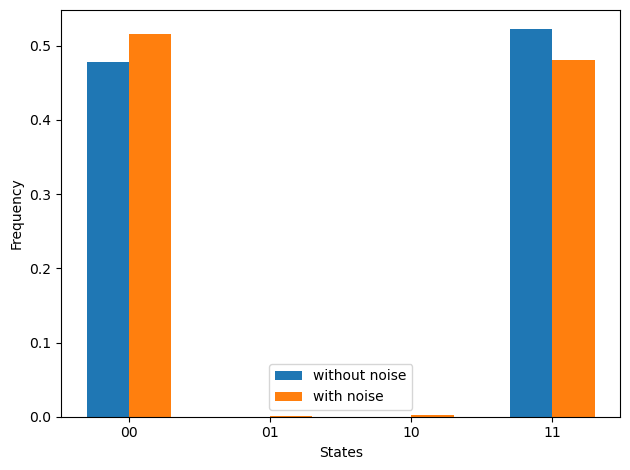

In [7]:
# bar plot
labels = ['without noise', 'with noise']
xlabel = 'States'
ylabel = 'Frequency'
plot_side_by_side_bars([dict_wo, dict_w], labels=labels, xlabel=xlabel, ylabel=ylabel)

We see that the presence of noise results in about 1% 'leakage' to '01' and '10' states.

## SWAP gate
Swap gate $\hat S |v\rang \otimes |w\rang=|w\rang\otimes|v\rang$. 
For 2 qubits $S=\frac{1}{2}(I\otimes I + X\otimes X+Y\otimes Y + Z\otimes Z)$.

As an evolution, $e^{-it\text{SWAP}}=e^{-itZ\otimes Z}(SH\otimes SH)e^{-itZ\otimes Z}[(HS^\dagger H)\otimes(HS^\dagger H)]e^{-itZ\otimes Z}(H\otimes H)$

We first construct a SWAP gate and apply to 2 qubits in $|01\rang$ state. 
We expect to get $|10\rang$.

In [72]:
def add_partial_swap(qc, qubit1, qubit2, t=np.pi):
    # equivalent to e^{-itSWAP}
    # by default t=pi, the circuit is equivalent to a full swap gate
    # ZZ
    qc.rzz(t, qubit1, qubit2)
    qc.barrier()

    # YY 
    qc.s(qubit1) 
    qc.s(qubit2) 
    qc.h(qubit1) 
    qc.h(qubit2) 
    qc.rzz(t, qubit1,qubit2)
    qc.h(qubit1) 
    qc.h(qubit2) 
    qc.sdg(qubit1) 
    qc.sdg(qubit2) 

    # XX
    qc.h(qubit1) 
    qc.h(qubit2) 
    qc.barrier()
    qc.rzz(t, qubit1,qubit2)
    qc.h(qubit1) 
    qc.h(qubit2)

In [8]:
# Define the time parameter
t = np.pi/5

# Define the circuit
qc = QuantumCircuit(2)
# make qubit 0 |1>
qc.x(1)
# Apply XX, YY, ZZ interactions with a parameter t
# Decompose e^{-i * (X⊗X + Y⊗Y + Z⊗Z) * t} using controlled gates

add_partial_swap(qc, 0, 1, t=t)

qc.measure_all()


print(qc.draw())

                         ░ ┌───┐┌───┐           ┌───┐┌─────┐┌───┐ ░            »
   q_0: ──────■──────────░─┤ S ├┤ H ├─■─────────┤ H ├┤ Sdg ├┤ H ├─░──■─────────»
        ┌───┐ │ZZ(2π/5)  ░ ├───┤├───┤ │ZZ(2π/5) ├───┤├─────┤├───┤ ░  │ZZ(2π/5) »
   q_1: ┤ X ├─■──────────░─┤ S ├┤ H ├─■─────────┤ H ├┤ Sdg ├┤ H ├─░──■─────────»
        └───┘            ░ └───┘└───┘           └───┘└─────┘└───┘ ░            »
meas: 2/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌───┐ ░ ┌─┐   
«   q_0: ┤ H ├─░─┤M├───
«        ├───┤ ░ └╥┘┌─┐
«   q_1: ┤ H ├─░──╫─┤M├
«        └───┘ ░  ║ └╥┘
«meas: 2/═════════╩══╩═
«                 0  1 


In [9]:
# plot SWAP interaction
t_space = np.linspace(0,np.pi, 30)
shots = int(5000/len(t_space))
dict_list_wo = []
for t in t_space:
    qc = QuantumCircuit(2)
    qc.x(1)
    add_partial_swap(qc, 0, 1, t=t)
    qc.measure_all()
    # without noise
    job = simulator_backend.run(qc, shots=shots)
    result_wo = job.result()
    dict_wo = get_keys_freq(result_wo)
    dict_list_wo.append(dict_wo)

In [10]:
conversion_wo = [1-d['01'] if '01' in d else 1 for d in dict_list_wo]

In [11]:
# plot SWAP interaction
t_space = np.linspace(0,np.pi, 30)
shots = int(5000/len(t_space))
dict_list_w = []
for t in t_space:
    qc = QuantumCircuit(2)
    qc.x(1)
    add_partial_swap(qc, 0, 1, t=t)
    qc.measure_all()
    # without noise
    job = simulator_backend.run(qc, shots=shots, noise_model='aria-1')
    result_w = job.result()
    dict_w = get_keys_freq(result_w)
    dict_list_w.append(dict_w)

In [12]:
conversion_w = [1-d['01'] if '01' in d else 1 for d in dict_list_w]

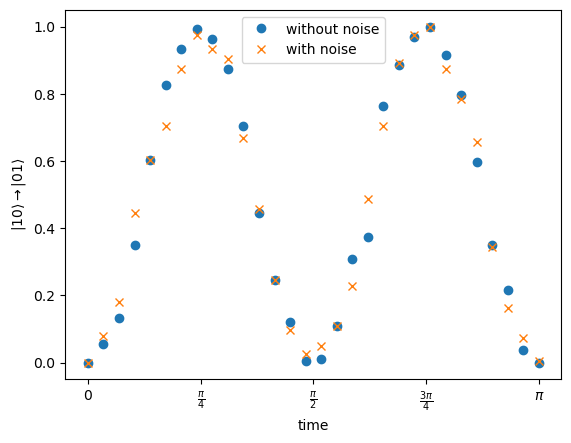

In [17]:
plt.plot(t_space, conversion_wo, 'o', label='without noise')
plt.plot(t_space, conversion_w, 'x', label='with noise')
xticks = np.arange(0,2*np.pi, np.pi/4)
xticks_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
                 r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xticks, xticks_labels)
plt.xlabel('time')
plt.ylabel(r'$|10\rangle\to|01\rangle$')
plt.legend()

In [ ]:
#TODO analyze error

# DME channel

DME channel defined by
$$
\hat E_t^{\rho}(\sigma)=\text{Tr}_1[e^{-it\text{SWAP}}(\rho\otimes\sigma)e^{it\text{SWAP}}]
$$

Expanding the exponent $e^{-it\text{SWAP}}=I-it\text{SWAP}+O(t^2)$, the DME channel can also be written as

$$
\hat E_t^{\rho}(\sigma)=\sigma - it[\rho, \sigma]+O(t^2) = e^{-is\rho}\sigma e^{is\rho}+O(t^2)
$$

To improve the accuracy, we trotterize by setting $t\to t/M$ and repeat DME $M$ times. Then we have
$$
(\hat E_{t/M}^{\rho}(\sigma))^M=e^{-is\rho}\sigma e^{is\rho}+O(t^2/M)
$$

In the previous section, we generated a circuit component that performs $e^{-it\text{SWAP}}$.
In this section, we then show the relationship between $$||(\hat E_{t/M}^{\rho}(\sigma))^M-e^{-is\rho}\sigma e^{is\rho}||$$ and Trotter steps $M$.

We first define $\sigma = |0\times 0|$ and $\rho = |+\times+|$, where $|+\rang=\frac{1}{\sqrt 2}(|0\rang + |1\rang)$

In [18]:
import scipy
# fidelity
from scipy.linalg import sqrtm
def fidelity(rho1, rho2):
    # Compute the square root of the first density matrix
    sqrt_rho1 = sqrtm(rho1)
    # Compute the matrix product of sqrt(rho1) * rho2 * sqrt(rho1)
    product = sqrt_rho1 @ rho2 @ sqrt_rho1    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)  
    return np.real(np.trace(sqrt_product)) ** 2

def instruct_evolution(sigma, rho, t):
    # e^-it\rho sigma e^it\rho
    V = scipy.linalg.expm( -1j * t * rho)
    V_d = scipy.linalg.expm( 1j * t * rho)
    expected_rho_W = V @ sigma @ V_d
    return expected_rho_W


In [71]:
# reference
sigma = np.outer(np.array([1,0]),np.array([1,0]))
rho = np.outer(np.array([1,1]),np.array([1,1]))/2
state_01 = np.kron(sigma,rho)

t = np.pi/2
evolved_state = instruct_evolution(sigma, rho, t)

# measure in Z basis
p_0 = np.real(np.trace(sigma @ evolved_state))
print(evolved_state)
print(p_0)

[[5.00000000e-01+0.00000000e+00j 1.11022302e-16+5.00000000e-01j]
 [2.77555756e-17-5.00000000e-01j 5.00000000e-01-8.32667268e-17j]]
0.5000000000000001


In [46]:
# 1 DME
shots = 200
qc = QuantumCircuit(2,1)
# qubit 2 |+>
qc.h(1)
add_partial_swap(qc, 0, 1, t=t)
qc.measure(0,0)
# without noise
job = simulator_backend.run(qc, shots=shots)
result_wo = job.result()
dict_wo = get_keys_freq(result_wo)
print(dict_wo['0'])

0.565


In [49]:
t_space = np.linspace(0, np.pi, 20)
shots = int(1000/len(t_space))
dict_list_wo = []
dict_list_w = []
expected_0 = []
for t in t_space:
    qc = QuantumCircuit(2,1)
    qc.h(1)
    add_partial_swap(qc, 0, 1, t=t)
    qc.measure(0,0)
    # without noise
    job = simulator_backend.run(qc, shots=shots)
    result_wo = job.result()
    dict_wo = get_keys_freq(result_wo)
    dict_list_wo.append(dict_wo)
    # with noise
    job = simulator_backend.run(qc, shots=shots, noise_model='aria-1')
    result_w = job.result()
    dict_w = get_keys_freq(result_w)
    dict_list_w.append(dict_w)
    # expected value
    evolved_state = instruct_evolution(sigma, rho, t) 
    p_0 = np.real(np.trace(sigma @ evolved_state))
    expected_0.append(p_0)

In [50]:
conversion_wo = [d['0'] if '0' in d else 0 for d in dict_list_wo]
conversion_w = [d['0'] if '0' in d else 0 for d in dict_list_w]

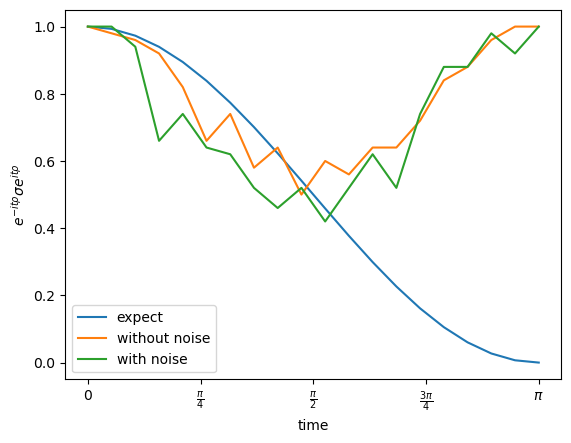

In [52]:
plt.plot(t_space, expected_0, label='expect')
plt.plot(t_space, conversion_wo, label='without noise')
plt.plot(t_space, conversion_w, label='with noise')
xticks = np.arange(0,np.pi+0.5, np.pi/4)
xticks_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
                 r'$\pi$']
plt.xticks(xticks, xticks_labels)
plt.xlabel('time')
plt.ylabel(r'$e^{-it\rho}\sigma e^{it\rho}$')
plt.legend()

[]

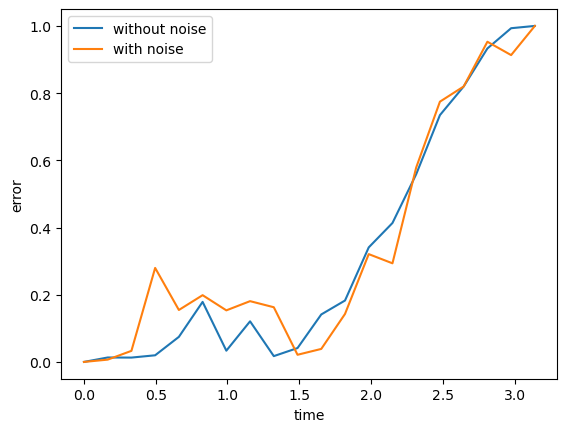

In [54]:
# plot error to t
diff_wo = [np.abs(expected_0[i]-conversion_wo[i]) for i in range(len(expected_0))]
diff_w = [np.abs(expected_0[i]-conversion_w[i]) for i in range(len(expected_0))]
plt.plot(t_space, diff_wo, label='without noise')
plt.plot(t_space, diff_w, label='with noise')
plt.xlabel("time")
plt.ylabel("error")
plt.legend()
plt.plot()

From the above two plots, we can see that for a small t<0.5, the DME channel approximates instruction evolution and the error grows quadratically with time. 

Next, we see how this error can be reduced by iterating DME operations.

In [73]:
def trotter_DME(qc, target_id, M, t):
    s = t/M
    for i in range(M):
        instruction_id = i+1
        add_partial_swap(qc, target_id, instruction_id, s)
        qc.measure(instruction_id, 0)
        qc.barrier()

In [74]:
# example 3 steps DME
M = 3
t = np.pi/2
qc = QuantumCircuit(M+1, 2)
# prepare instruction qubits |+>
for i in range(M):
    qc.h(i+1)
trotter_DME(qc, 0, M, t)
qc.measure(0, 1)
qc.draw()


░ ┌───┐┌───┐          ┌───┐┌─────┐┌───┐ ░           ┌───┐»
q_0: ──────■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░──■────────┤ H ├»
     ┌───┐ │ZZ(π/6)  ░ ├───┤├───┤ │ZZ(π/6) ├───┤├─────┤├───┤ ░  │ZZ(π/6) ├───┤»
q_1: ┤ H ├─■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░──■────────┤ H ├»
     ├───┤           ░ └───┘└───┘          └───┘└─────┘└───┘ ░           └───┘»
q_2: ┤ H ├───────────░───────────────────────────────────────░────────────────»
     ├───┤           ░                                       ░                »
q_3: ┤ H ├───────────░───────────────────────────────────────░────────────────»
     └───┘           ░                                       ░                »
c: 2/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«         ░            ░ ┌───┐┌───┐          ┌───┐┌─────┐┌───┐ ░           »
«q_0: ────░──■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░──■────────»
«     ┌─┐ ░  │         ░ └───┘└───┘ │        └───┘└─────┘└───┘ ░  │        »
«q_1: ┤M├─░──┼─────────░────────────┼──────────────────────────░──┼────────»
«     └╥┘ ░  │ZZ(π/6)  ░ ┌───┐┌───┐ │ZZ(π/6) ┌───┐┌─────┐┌───┐ ░  │ZZ(π/6) »
«q_2: ─╫──░──■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░──■────────»
«      ║  ░            ░ └───┘└───┘          └───┘└─────┘└───┘ ░           »
«q_3: ─╫──░────────────░───────────────────────────────────────░───────────»
«      ║  ░            ░                                       ░           »
«c: 2/═╩═══════════════════════════════════════════════════════════════════»
«      0                                                                   »
«     ┌───┐    ░            ░ ┌───┐┌───┐          ┌───┐┌─────┐┌───┐ ░ »
«q_0: ┤ H ├────░──■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░─»
«     └───┘    ░  │         ░ └───┘└───┘ │        └───┘└─────┘└───┘ ░ »
«q_1: ─────────░──┼─────────░────────────┼──────────────────────────░─»
«     ┌───┐┌─┐ ░  │         ░            │                          ░ »
«q_2: ┤ H ├┤M├─░──┼─────────░────────────┼──────────────────────────░─»
«     └───┘└╥┘ ░  │ZZ(π/6)  ░ ┌───┐┌───┐ │ZZ(π/6) ┌───┐┌─────┐┌───┐ ░ »
«q_3: ──────╫──░──■─────────░─┤ S ├┤ H ├─■────────┤ H ├┤ Sdg ├┤ H ├─░─»
«           ║  ░            ░ └───┘└───┘          └───┘└─────┘└───┘ ░ »
«c: 2/══════╩═════════════════════════════════════════════════════════»
«           0                                                         »
«               ┌───┐    ░ ┌─┐
«q_0: ─■────────┤ H ├────░─┤M├
«      │        └───┘    ░ └╥┘
«q_1: ─┼─────────────────░──╫─
«      │                 ░  ║ 
«q_2: ─┼─────────────────░──╫─
«      │ZZ(π/6) ┌───┐┌─┐ ░  ║ 
«q_3: ─■────────┤ H ├┤M├─░──╫─
«               └───┘└╥┘ ░  ║ 
«c: 2/════════════════╩═════╩═
«                     0     1

In [75]:
shots = 1000
job = simulator_backend.run(qc, shots=shots)
result_wo = job.result()
job = simulator_backend.run(qc, shots=shots, noise_model='aria-1')
result_w = job.result()

In [76]:
dict_wo = get_keys_freq(result_wo)
dict_w = get_keys_freq(result_w)
print(dict_wo)
print(dict_w)
# Note that because target qubit-0 measured after, the last bit indictates its state '01' means target in '1'

{'00': 0.323, '01': 0.351, '10': 0.168, '11': 0.158}
{'00': 0.32, '01': 0.374, '10': 0.163, '11': 0.143}


In [78]:
target_meas_wo = sum(value for key, value in dict_wo.items() if key[::-1].startswith('0'))
target_meas_w = sum(value for key, value in dict_w.items() if key[::-1].startswith('0'))
print(target_meas_wo)
print(target_meas_w)

0.491
0.483


We see that for $t=\pi/2$, with 3 DME steps we can get a good approximation for the target evolution on $\sigma$.

Next, we set $t=0.79$, vary M between 1 to 20 and observe the conversion rate difference.

In [84]:
M_range = 20
t = 0.79
results_wo = []
results_w = []
shots = 500
for m in range(1,M_range+1):
    print(m)
    qc = QuantumCircuit(m+1, 2)
    # prepare instruction qubits |+>
    for i in range(m):
        qc.h(i+1)
    trotter_DME(qc, 0, m, t)
    qc.measure(0, 1)
    job = simulator_backend.run(qc, shots=shots)
    result_wo = job.result()
    results_wo.append(result_wo)
    job = simulator_backend.run(qc, shots=shots, noise_model='aria-1')
    result_w = job.result()
    results_w.append(result_w)

# process reading
freq_wo = [get_keys_freq(results_wo[i]) for i in range(len(results_wo))]
freq_w = [get_keys_freq(results_w[i]) for i in range(len(results_w))]
conversion_wo = [sum(value for key, value in freq_wo[i].items() if key[::-1].startswith('0')) for i in range(len(freq_wo))]
conversion_w = [sum(value for key, value in freq_w[i].items() if key[::-1].startswith('0')) for i in range(len(freq_w))]
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [85]:
#reference
evolved_state = instruct_evolution(sigma, rho, t)

# measure in Z basis
p_0 = np.real(np.trace(sigma @ evolved_state))
print(p_0)
print(conversion_wo)
print(conversion_w)

0.851922657826118
[0.72, 0.782, 0.804, 0.8300000000000001, 0.864, 0.824, 0.844, 0.854, 0.796, 0.81, 0.8380000000000001, 0.848, 0.86, 0.8420000000000001, 0.852, 0.84, 0.8, 0.858, 0.84, 0.866]
[0.702, 0.782, 0.812, 0.758, 0.742, 0.756, 0.756, 0.766, 0.762, 0.758, 0.728, 0.714, 0.688, 0.704, 0.658, 0.69, 0.714, 0.69, 0.63, 0.612]


Text(0.5, 1.0, '$t=0.79$')

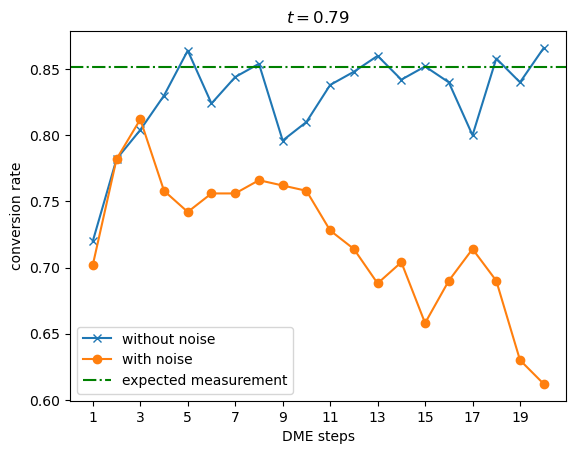

In [101]:
plt.plot(np.arange(1,21), conversion_wo, marker='x', label='without noise')
plt.plot(np.arange(1,21), conversion_w, marker='o', label='with noise')
plt.axhline(p_0, linestyle='-.', color='g', label='expected measurement')
plt.legend()
plt.xticks(np.arange(1,21,2))
plt.xlabel('DME steps')
plt.ylabel('conversion rate')
plt.title(r'$t=0.79$')